In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
import random
import cv2

import keras

import keras_cv

import tensorflow as tf


In [3]:
sns.set_style('darkgrid')

In [4]:
base_dir = '/home/nima/dataset/Brain_Tumor'
os.listdir(base_dir)

['Training', 'Testing']

In [5]:
train_path = os.path.join(base_dir, 'Training')
test_path = os.path.join(base_dir, 'Testing')

In [6]:
classes = [class_name for class_name in os.listdir(train_path)]
classes

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

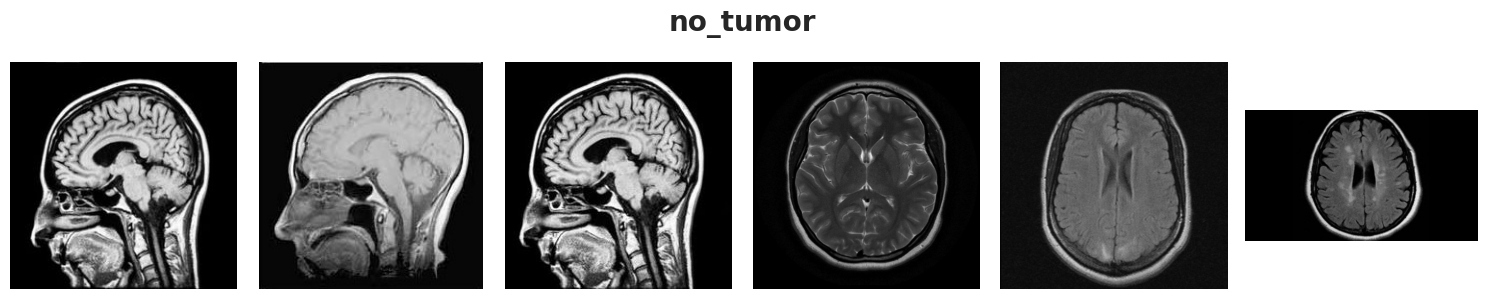

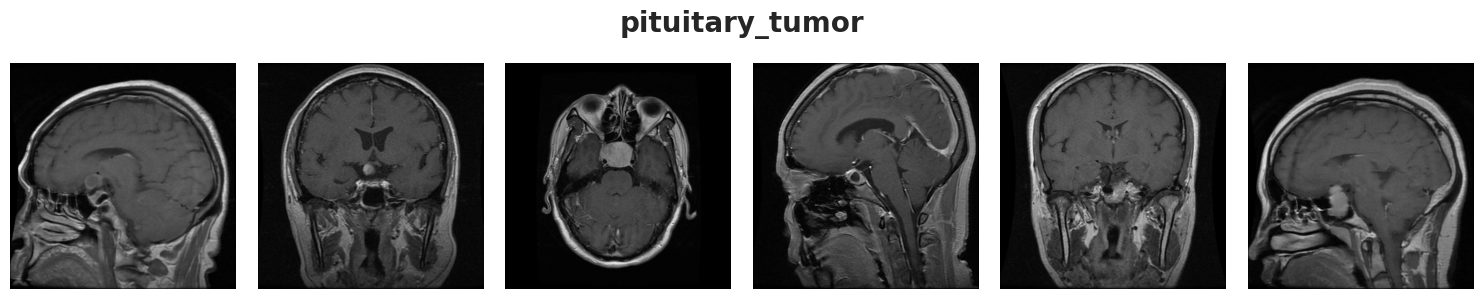

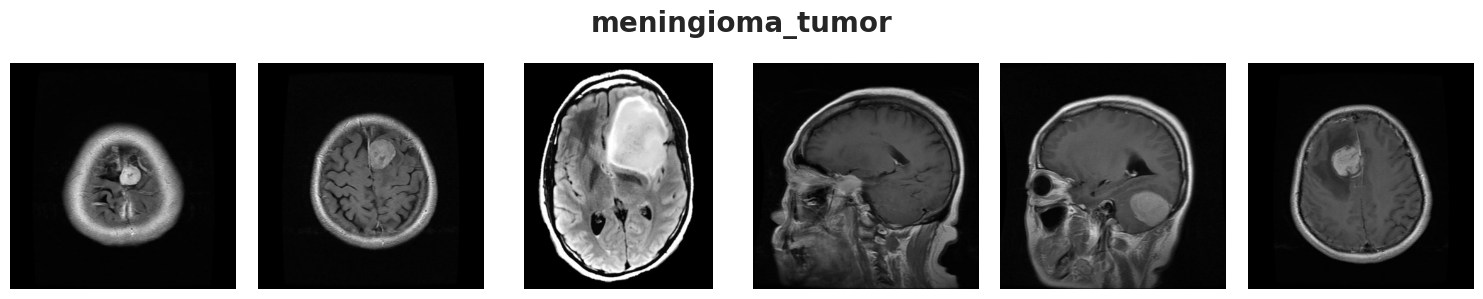

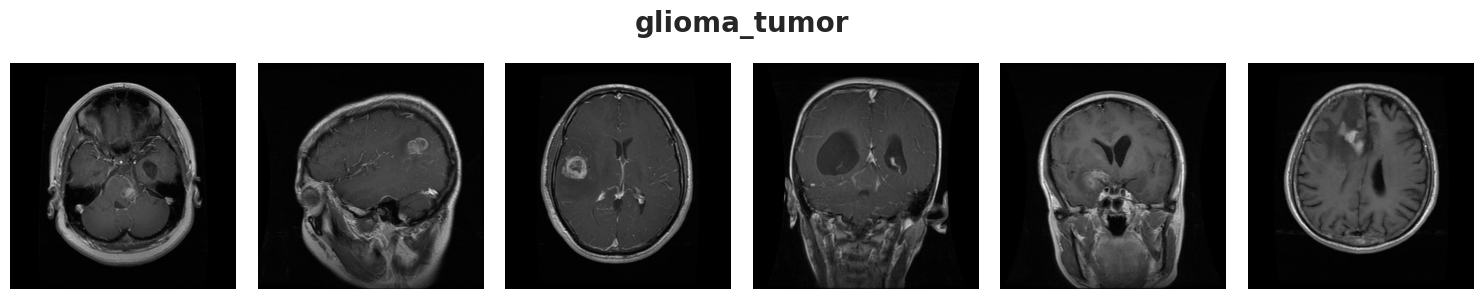

In [7]:
for class_name in classes :
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    class_path = os.path.join(train_path, class_name)
    files = os.listdir(class_path)
    random_images = random.choices(files, k=6)
    for i in range(6) :
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        img = os.path.join(class_path ,random_images[i])
        img = keras.utils.load_img(img)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()

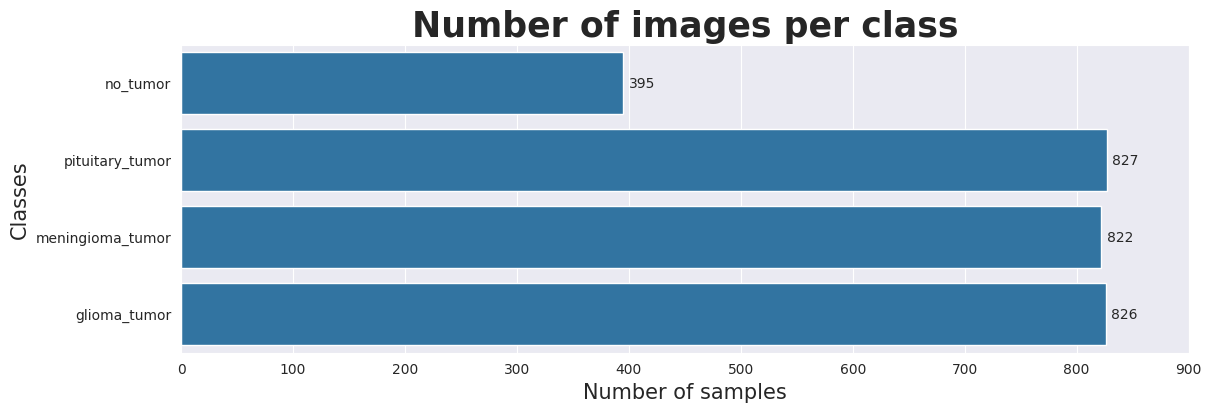

In [8]:
counts = []
for class_name in classes :
    class_path = os.path.join(train_path, class_name)
    counts.append(len(os.listdir(class_path)))


plt.figure(figsize=(13, 4))
ax = sns.barplot(y=classes, x=counts)
ax.set_xticks(range(0, 950, 100))
# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
plt.title('Number of images per class', fontsize=25, fontweight='bold')
plt.ylabel('Classes', fontsize=15)
plt.xlabel('Number of samples', fontsize=15)
plt.show()

In [20]:
sum_count_before = sum(counts)
print(colored(f'Number of all images is : {sum_count_before}', 'blue', attrs=['bold']))

Number of all images is : 8529


# augmentation

Base on article :
https://link.springer.com/article/10.1007/s10462-023-10453-z#:~:text=2.1%20Augmentation%20of%20brain%20MR,several%20tasks%20(Table%201).
there are several way to augmentate MRI images.


### RandomBrightness

A preprocessing layer which randomly adjusts brightness during training.

This layer will randomly increase/reduce the brightness for the input RGB images. At inference time, the output will be identical to the input. Call the layer with training=True to adjust the brightness of the input.

Note: This layer is safe to use inside a tf.data pipeline (independently of which backend you're using).

Arguments

factor: Float or a list/tuple of 2 floats between -1.0 and 1.0. The factor is used to determine the lower bound and upper bound of the brightness adjustment. A float value will be chosen randomly between the limits. When -1.0 is chosen, the output image will be black, and when 1.0 is chosen, the image will be fully white. When only one float is provided, eg, 0.2, then -0.2 will be used for lower bound and 0.2 will be used for upper bound.

In [10]:
# Averaging Blur
def blur(img) :
    """ Apply Averaging Blur to image """
    # return cv2.blur(img2,(10,10))
    kernel = np.ones((5,5),np.float32)/50
    return cv2.filter2D(img,-1,kernel)
   
 
# Gaussian Blurring 
def gausian_blur(img) :
    """ Apply Gaussian Blurring to image """
    return cv2.GaussianBlur(img, (9, 9), -0.5)  

# RandomBrightness
def RandomBrightness(img) :
    """ Change Brighness of image in a defined range """
    RB = keras_cv.layers.RandomBrightness(factor=(-0.25, 0.25))
    return keras.utils.img_to_array(RB(img, training=True))

# RandomAugmentation
def RandomAugmentation(img) :
    """ Apply random augmentations """
    rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    magnitude=0.5,
    magnitude_stddev=0.2,
    rate=0.2)
    return keras.utils.img_to_array(rand_augment(img))

# add_gaussian_noise
def add_gaussian_noise(image, mean=0, std=0.5):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# downsample_upsample
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [11]:
def plot_augments(img) :
    fig, ax = plt.subplots(1, 7, figsize=(15, 4))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    
    ax[1].imshow(blur(img))
    ax[1].set_title('Blur')
    
    ax[2].imshow(gausian_blur(img))
    ax[2].set_title('Gausian_Blur')
    
    ax[3].imshow(RandomAugmentation(img))
    ax[3].set_title('Rand_Augment')
    
    ax[4].imshow(RandomBrightness(img))
    ax[4].set_title('Rand_Bright')
    
    ax[5].imshow(add_gaussian_noise(img))
    ax[5].set_title('gaussian_noise ')

    ax[6].imshow(downsample_upsample(img))
    ax[6].set_title('dowup_sample ')
    
    for i in range(7) :
        ax[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


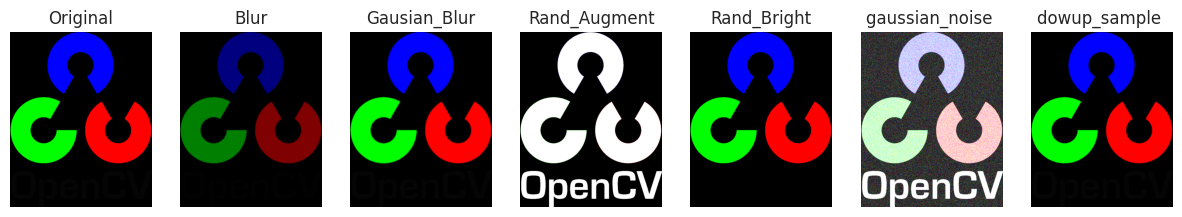

In [12]:
img = cv2.imread('/home/nima/Downloads/cv.png')
plot_augments(img)

# Add augmentations to dataset

In [13]:
augmentations = ['Blur', 'Gausian_Blur', 'Rand_Augment', 'Rand_Bright', 'gaussian_noise', 'downup_sample']
def add_augmantation(train_path, ) :
    for class_name in classes :
        class_path = os.path.join(train_path, class_name)
        # print(class_path)
        files = os.listdir(class_path)
        for file in files :
            file_path = os.path.join(class_path, file)

            img = keras.utils.load_img(file_path)
            img = keras.utils.img_to_array(img)
            chosen_methods = random.sample(augmentations, k=random.randint(1, 3))
            #
            if 'Blur' in chosen_methods:
                img = blur(img)
                new_img_path = os.path.join(class_path, f"blur_{file}")
                keras.utils.save_img(new_img_path, img)
            if 'Gausian_Blur' in chosen_methods :
                img = gausian_blur(img)
                new_img_path = os.path.join(class_path, f"gausian_blur_{file}")
                keras.utils.save_img(new_img_path, img)
            if 'Rand_Augment' in chosen_methods :
                img = RandomAugmentation(img)
                new_img_path = os.path.join(class_path, f"rand_aug_{file}")
                keras.utils.save_img(new_img_path, img)
            if 'Rand_Bright' in chosen_methods :
                img = RandomBrightness(img)
                new_img_path = os.path.join(class_path, f"rand_bright_{file}")
                keras.utils.save_img(new_img_path, img)
            if 'gaussian_noise' in chosen_methods :
                img = add_gaussian_noise(img)
                new_img_path = os.path.join(class_path, f"gausian_noise_{file}")
                keras.utils.save_img(new_img_path, img)
            if 'downup_sample' in chosen_methods :
                img = downsample_upsample(img)
                new_img_path = os.path.join(class_path, f"down_up_{file}")
                keras.utils.save_img(new_img_path, img)

In [14]:
add_augmantation(train_path)

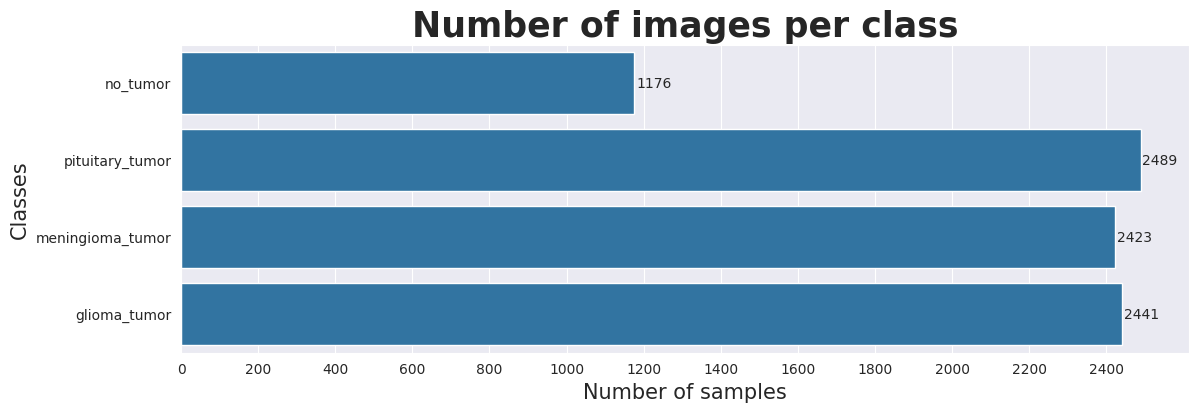

In [15]:
counts = []
for class_name in classes :
    class_path = os.path.join(train_path, class_name)
    counts.append(len(os.listdir(class_path)))


plt.figure(figsize=(13, 4))
ax = sns.barplot(y=classes, x=counts)
ax.set_xticks(range(0, 2600, 200))
# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
plt.title('Number of images per class', fontsize=25, fontweight='bold')
plt.ylabel('Classes', fontsize=15)
plt.xlabel('Number of samples', fontsize=15)
plt.show()

In [19]:
sum_count_after = sum(counts)
print(colored(f'Number of all images after Augmantation is : {sum_count_after}', 'blue', attrs=['bold']))

Number of all images after Augmantation is : 8529


In [17]:
print(colored(f'{sum_count_after-sum_count_befor} images added by Augmentattion process.', 'green', attrs=['bold']))

5659 images added by Augmentattion process.


# Convert to tensorflow.dataset

In [21]:
train_full = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    seed=42,
    batch_size=32,
    image_size=(224, 224)
 )

Found 8529 files belonging to 4 classes.


In [22]:
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    seed=42,
    batch_size=32,
    image_size=(224, 224)
)

Found 394 files belonging to 4 classes.


# Create train and validatin dataset from train_full

In [34]:
num_of_full_train_batches = len(list(train_full))
print(colored(f'number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

number of batches in train_full : 267


In [26]:
# train = 0.85 % data
# validation = 0.15 data

In [35]:
num_train_batches = int(num_of_train_batches * 0.85)
num_valid_batches = num_of_train_batches - int(num_of_train_batches * 0.85)

print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_batches}', 'blue', attrs=['bold']))

Number of  Train  batches : 226
Number of Validation batches : 41


In [36]:
train_full = train_full.shuffle(buffer_size=3)
train_ds = train_full.take(num_train_batches)
valid_ds = train_full.skip(num_train_batches)

In [38]:
print(colored(f'Number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))
print(colored(f'Number of test  batches : {len(list(test_ds))}', 'green', attrs=['bold']))

Number of train batches : 226
Number of valid batches : 41
Number of test  batches : 13


In [41]:
pre_trained_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

In [42]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [43]:
# Name of layers in ResNet50V2
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer_1
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d_3
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_bl

In [44]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'conv5_block1_preact_bn' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [56]:
# Add custom layers on top of the base model
model = keras.models.Sequential()
model.add(pre_trained_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4, activation='softmax'))

In [58]:
model.build()

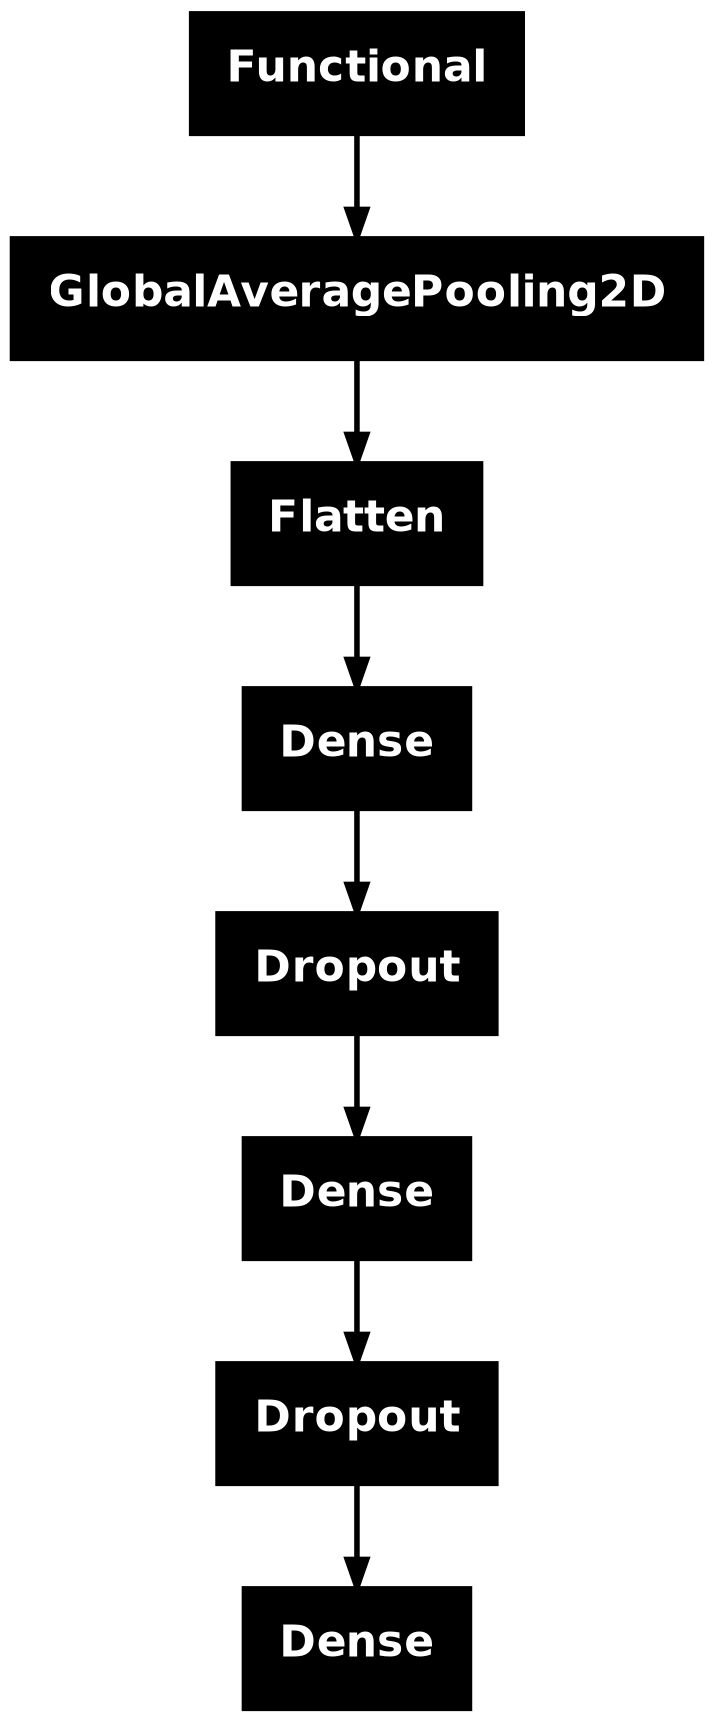

In [65]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [60]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# CallBacks

In [69]:
# Model CheckPoint
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

In [61]:
history = model.fit(train_ds, 
                    epochs=2,
                    validation_data=valid_ds,
                   )

Epoch 1/2


I0000 00:00:1708700477.908743   26183 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708700477.965820   26183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5669 - loss: 0.9888

W0000 00:00:1708700517.289314   26183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/226 ━━━━━━━━━━━━━━━━━━━━ 90s 235ms/step - accuracy: 0.5675 - loss: 0.9876 - val_accuracy: 0.8489 - val_loss: 0.3766
Epoch 2/2


W0000 00:00:1708700531.027860   26183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/226 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - accuracy: 0.8688 - loss: 0.3398 - val_accuracy: 0.9291 - val_loss: 0.2168


In [ ]:
# create train_df with columns=['file_path', class]

In [ ]:
data = []
train_count = {}
for class_name in classes :
    class_path = os.path.join(train_ds, class_name)

    class_count = len(os.listdir(class_path))
    train_count[class_name]=class_count
    data.extend(
        [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]
    )
train_df = pd.DataFrame(data, columns=['file_path', 'label'])

print('Shape of Train DataFrame : ', train_df.shape)
print('-'*30)
for class_name, class_count in train_count.items() :
    print(class_name, ':', class_count)

In [ ]:
data = []
test_count = {}
for class_name in classes :
    class_path = os.path.join(test_ds, class_name)

    class_count = len(os.listdir(class_path))
    test_count[class_name]=class_count
    data.extend(
        [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]
    )
test_df = pd.DataFrame(data, columns=['file_path', 'label'])
print('Shape of Test DataFrame : ', test_df.shape)
print('-'*30)
for class_name, class_count in test_count.items() :
    print(class_name, ':', class_count)

In [ ]:
%who_ls

In [ ]:
# Freeup some space with deleting unused variables



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_steps_per_epoch = train_df.shape[0]//BATCH_SIZE
train_steps_per_epoch

In [ ]:
num_classes = len(classes)
num_classes

In [ ]:
def preprocess_input(image, label) :
    resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True)
    
    image = tf.cast(image, tf.float32)
    
    return resizing(image), tf.one_hot(label, num_classes)

In [ ]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=4
)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=train_steps_per_epoch
)